## Import Libraries

In [1]:
import math
import datetime

import numpy as np

import pandas as pd
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data Load

In [3]:
# Loading Data
df = pd.read_csv("Natural Gas Futures Historical Data_2012-2022.csv", header = 0, parse_dates=[0])
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df

Date  Price   Open   High    Low     Vol. Change %
0    2022-06-15  574.0  571.3  576.1  565.0   17.10K    0.17%
1    2022-06-14  573.0  678.7  693.3  551.6   90.20K  -14.71%
2    2022-06-13  671.8  688.3  697.2  656.6  107.54K   -2.75%
3    2022-06-10  690.8  697.8  712.8  674.2   78.64K   -0.07%
4    2022-06-09  691.3  658.5  698.2  625.3  149.22K    1.01%
...         ...    ...    ...    ...    ...      ...      ...
2686 2012-05-21  146.8  149.5  150.4  145.2   81.35K   -2.59%
2687 2012-05-19  150.7  147.5  151.5  147.5    6.21K    2.45%
2688 2012-05-18  147.1  139.8  148.1  139.8  108.03K    6.36%
2689 2012-05-17  138.3  142.8  146.1  136.7  118.45K   -2.61%
2690 2012-05-16  142.0  135.0  142.5  135.0  103.93K    5.42%

[2691 rows x 7 columns]

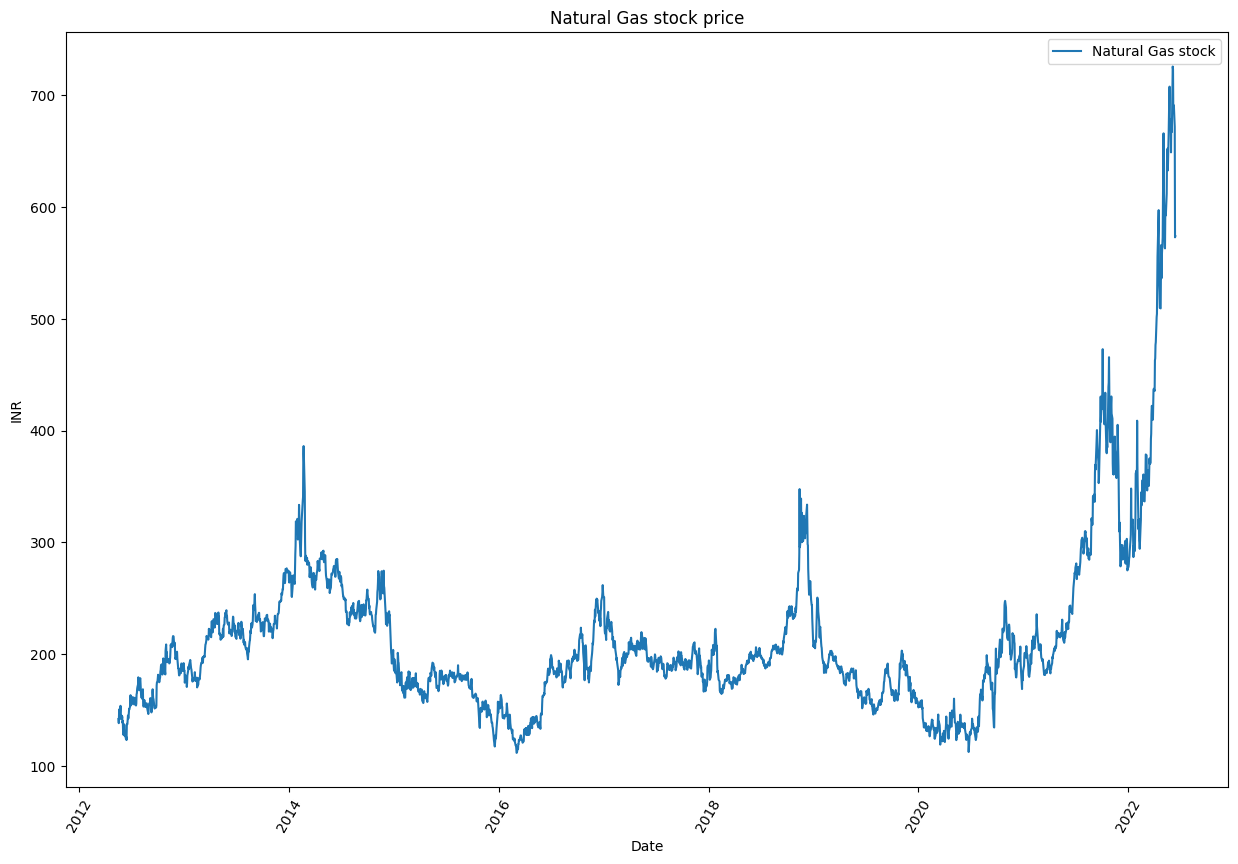

In [4]:
plt.figure(figsize=(15, 10), dpi=100)
plt.plot(df['Date'], df['Price'], label='Natural Gas stock')
plt.xlabel('Date')
plt.ylabel('INR')
plt.xticks(rotation = 60)
plt.title('Natural Gas stock price')
plt.legend()
plt.show()

## Technical Indicators

In [5]:
def tech_indicators(df):
    # creating moving average for 7 days and 21 days
    df['ma7'] = df['Price'].rolling(window=7, min_periods=1).mean()
    df['ma21'] = df['Price'].rolling(window=21, min_periods=1).mean()

    # create MACD(Moving average convergence divergence)
    # ewma(Exponentially-weighted moving average)
    df['26ema'] = df['Price'].ewm(span= 26, adjust=False).mean()
    df['12ema'] = df['Price'].ewm(span= 12, adjust=False).mean()
    df['MACD'] = (df['12ema']-df['26ema'])
    
    # Create Bollinger Bands
    ## size of moving window is 20
    df['20sd'] = df['Price'].rolling(window=20, min_periods=1).std()
    df['upper_band'] = df['ma21'] + (df['20sd']*2)
    df['lower_band'] = df['ma21'] - (df['20sd']*2)
    
    # Exponential moving average
    ## ewm exponentially weighted
    df['ema'] = df['Price'].ewm(com=0.5).mean()
    
    # momentum
    df['momentum'] = df['Price'] - 1
    
    df['log_momentum'] = np.log(df['momentum'])
    
    return df

In [6]:
df_tech_indi = tech_indicators(df[['Price']])
df_tech_indi.head(22)

Price         ma7        ma21       26ema       12ema       MACD  \
0   574.0  574.000000  574.000000  574.000000  574.000000   0.000000   
1   573.0  573.500000  573.500000  573.925926  573.846154  -0.079772   
2   671.8  606.266667  606.266667  581.175857  588.915976   7.740119   
3   690.8  627.400000  627.400000  589.296164  604.590442  15.294277   
4   691.3  640.180000  640.180000  596.852004  617.930374  21.078370   
5   684.4  647.550000  647.550000  603.337041  628.156470  24.819429   
6   723.3  658.371429  658.371429  612.223186  642.793936  30.570750   
7   725.8  680.057143  666.800000  620.636283  655.564100  34.927817   
8   667.2  693.514286  666.844444  624.085447  657.354238  33.268791   
9   672.9  693.671429  667.450000  627.701340  659.745894  32.044554   
10  674.9  691.400000  668.127273  631.197537  662.077295  30.879758   
11  649.0  685.357143  666.533333  632.516238  660.065403  27.549165   
12  678.8  684.557143  667.476923  635.944665  662.947649  27.002984   
13  670.5  677.014286  667.692857  638.504319  664.109549  25.605230   
14  707.8  674.442857  670.366667  643.637333  670.831157  27.193824   
15  698.6  678.928571  672.131250  647.708641  675.103287  27.394645   
16  682.3  680.271429  672.729412  650.270964  676.210473  25.939509   
17  667.8  679.257143  672.455556  651.569411  674.916554  23.347143   
18  632.8  676.942857  670.368421  650.179085  668.437084  18.258000   
19  652.3  673.157143  669.465000  650.336189  665.954456  15.618267   
20  650.5  670.300000  668.561905  650.348324  663.576847  13.228524   
21  640.2  660.642857  671.714286  649.596596  659.980409  10.383813   

         20sd  upper_band  lower_band         ema  momentum  log_momentum  
0         NaN         NaN         NaN  574.000000     573.0      6.350886  
1    0.707107  574.914214  572.085786  573.250000     572.0      6.349139  
2   56.755734  719.778135  492.755199  641.476923     670.8      6.508471  
3   62.721182  752.842364  501.957636  674.770000     689.8      6.536402  
4   61.376722  762.933444  517.426556  685.835537     690.3      6.537126  
5   57.789125  763.128251  531.971749  684.877198     683.4      6.527080  
6   60.022571  778.416571  538.326286  710.504117     722.3      6.582441  
7   60.467866  787.735733  545.864267  720.702927     724.8      6.585896  
8   56.562667  779.969778  553.719111  685.032497     666.2      6.501590  
9   53.362164  774.174328  560.725672  676.944029     671.9      6.510110  
10  50.673604  769.474482  566.780064  675.581335     673.9      6.513082  
11  48.629870  763.793073  569.273594  657.860412     648.0      6.473891  
12  46.683690  760.844303  574.109543  671.820146     677.8      6.518852  
13  44.859515  757.411887  577.973827  670.940048     669.5      6.506531  
14  44.450802  759.268271  581.465062  695.513351     706.8      6.560748  
15  43.519754  759.170757  585.091743  697.571117     697.6      6.547646  
16  42.209933  757.149278  588.309545  687.390372     681.3      6.524003  
17  40.966130  754.387815  590.523296  674.330124     666.8      6.502490  
18  40.838164  752.044748  588.692094  646.643375     631.8      6.448573  
19  39.953753  749.372506  589.557494  650.414458     651.3      6.478970  
20  33.468947  735.499799  601.624011  650.471486     649.5      6.476203  
21  25.229797  722.173879  621.254693  643.623829     639.2      6.460217

In [7]:
def plot_tech_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Natural Gas - last {} days.'.format(last_days))
    plt.ylabel('INR')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

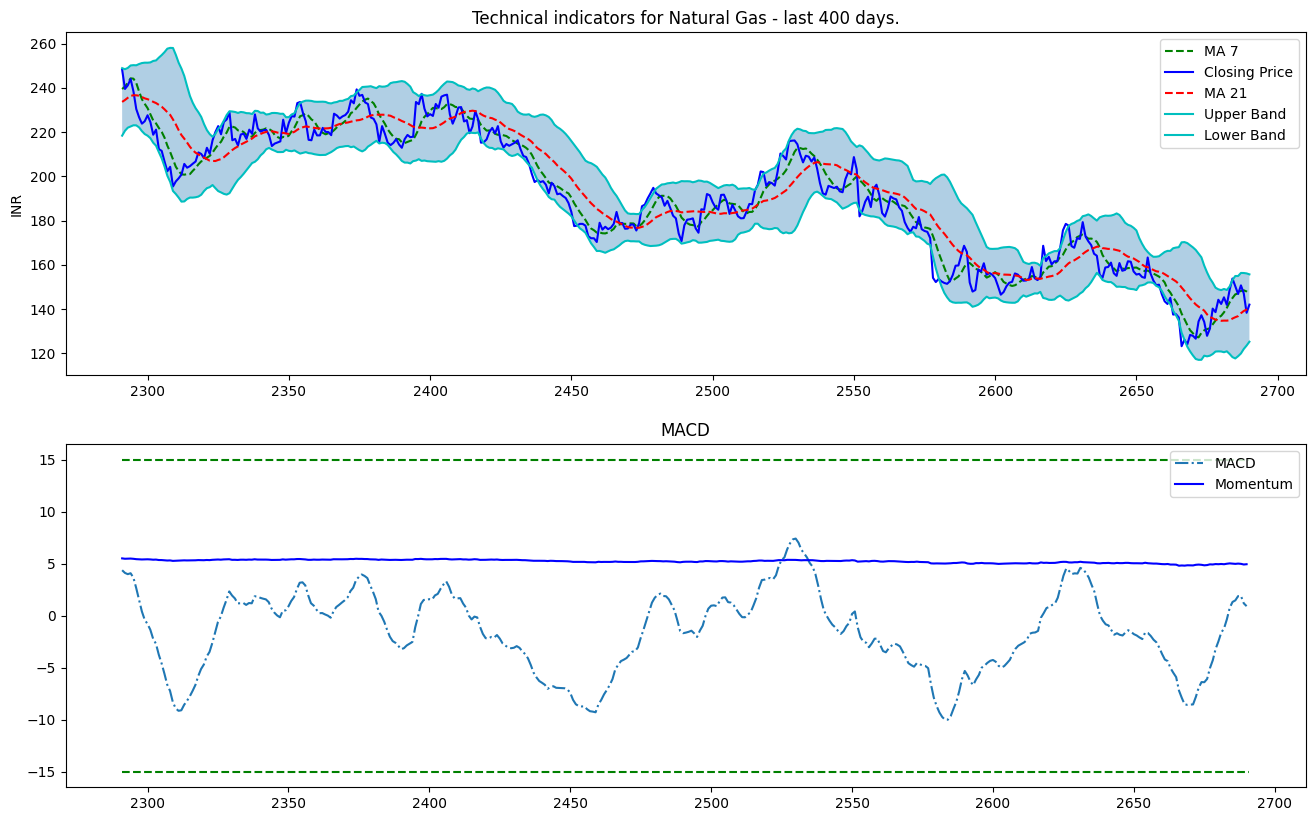

In [8]:
plot_tech_indicators(df_tech_indi, 400)

## Fourier Transform

In [9]:
df_FT = df[['Date', 'Price']]
df_FT

Date  Price
0    2022-06-15  574.0
1    2022-06-14  573.0
2    2022-06-13  671.8
3    2022-06-10  690.8
4    2022-06-09  691.3
...         ...    ...
2686 2012-05-21  146.8
2687 2012-05-19  150.7
2688 2012-05-18  147.1
2689 2012-05-17  138.3
2690 2012-05-16  142.0

[2691 rows x 2 columns]

In [10]:
close_fft = np.fft.fft(np.asarray(df_FT['Price'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

In [11]:
fft_df

fft       absolute     angle
0      575584000000.8+0.0000000j  575584.800000  0.000000
1     54947.818846+11236.488728j   56084.948738  0.201713
2      31014.968670+7869.684847j   31997.815881  0.248494
3     17869.388668-58434.764838j   61105.947280 -1.274026
4     26582.441674-55025.913013j   61110.369891 -1.120768
...                          ...            ...       ...
2686   4002.344706+14115.405389j   14671.858520  1.294504
2687  26582.441674+55025.913013j   61110.369891  1.120768
2688  17869.388668+58434.764838j   61105.947280  1.274026
2689   31014.968670-7869.684847j   31997.815881 -0.248494
2690  54947.818846-11236.488728j   56084.948738 -0.201713

[2691 rows x 3 columns]

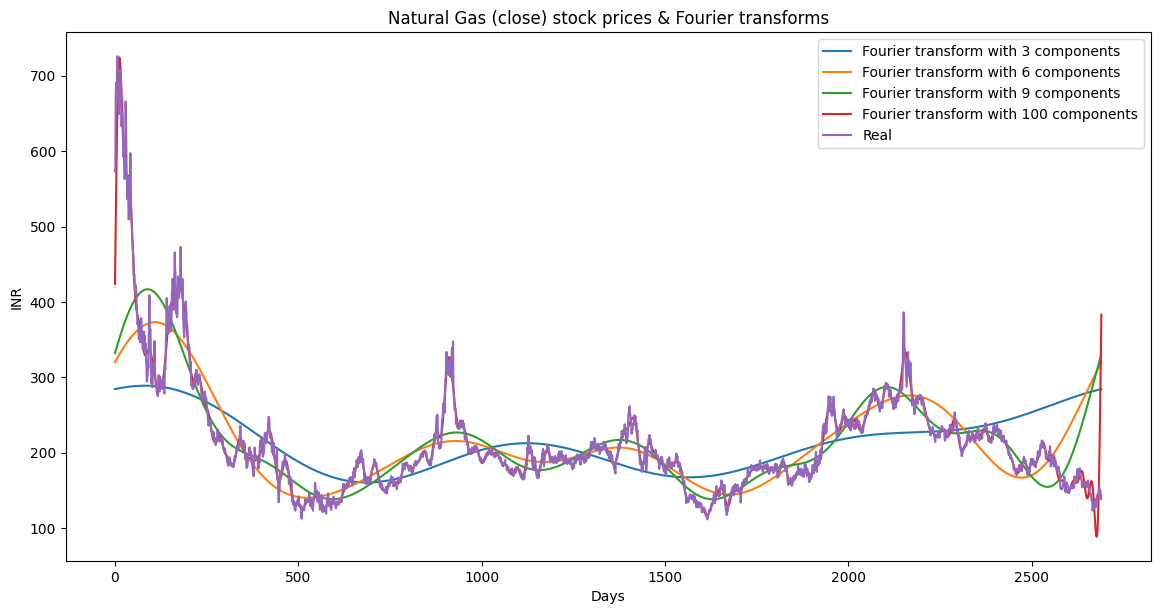

In [12]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(df_FT['Price'],  label='Real')
plt.xlabel('Days')
plt.ylabel('INR')
plt.title('Natural Gas (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

## ARIMA (Auto Regressive Integrated Moving Average)

In [13]:
series = df_FT['Price']
model = ARIMA(series, order = (5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 2691
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9396.997
Date:                Fri, 17 Jun 2022   AIC                          18805.994
Time:                        13:46:55   BIC                          18841.378
Sample:                             0   HQIC                         18818.792
                               - 2691                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0183      0.008      2.178      0.029       0.002       0.035
ar.L2         -0.0563      0.010     -5.804      0.000      -0.075      -0.037
ar.L3          0.0099      0.009      1.114      0.2

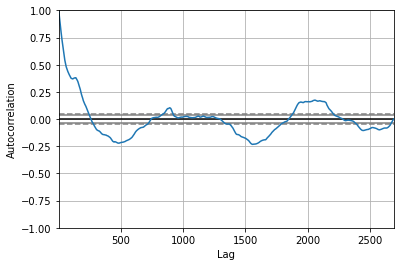

<Figure size 432x288 with 0 Axes>

In [14]:
autocorrelation_plot(series)
plt.figure()
plt.show() 

In [15]:
X = series.values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
# train, test = train_test_split(X, test_size=0.3)
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast() 
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [16]:
mse = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse)

Test MSE: 30.146


In [17]:
result = model_fit.get_forecast()
forecast = result.predicted_mean
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
    ci = result.conf_int(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

80.0% Confidence Interval: 138.825 between 128.622 and 149.027
90.0% Confidence Interval: 138.825 between 125.730 and 151.919
95.0% Confidence Interval: 138.825 between 123.222 and 154.428
99.0% Confidence Interval: 138.825 between 118.319 and 159.331


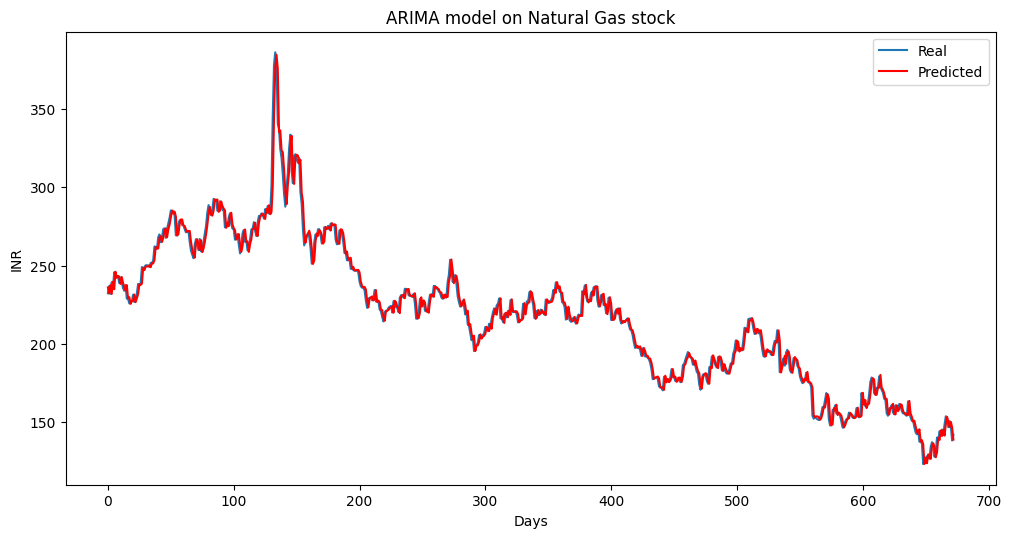

In [18]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('INR')
plt.title('ARIMA model on Natural Gas stock')
plt.legend()
plt.show()

## Feature Importance with XGBoost

In [19]:
def feature_imp(df):
    data = df.copy()
#     data = data.drop(['Change %', 'Vol.', 'fft'], axis=1)
#     data = data.drop(['log_momentum', 'ema'], axis=1)
    y = data['Price']
    X = data.iloc[:,1:]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.25, random_state=5)

    return (X_train, Y_train), (X_test, Y_test)

In [20]:
merge_df = pd.merge(df_tech_indi, fft_df, left_index=True, right_index=True, how='inner')
merge_df

Price         ma7        ma21       26ema       12ema       MACD  \
0     574.0  574.000000  574.000000  574.000000  574.000000   0.000000   
1     573.0  573.500000  573.500000  573.925926  573.846154  -0.079772   
2     671.8  606.266667  606.266667  581.175857  588.915976   7.740119   
3     690.8  627.400000  627.400000  589.296164  604.590442  15.294277   
4     691.3  640.180000  640.180000  596.852004  617.930374  21.078370   
...     ...         ...         ...         ...         ...        ...   
2686  146.8  147.014286  136.809524  142.665862  144.137850   1.471988   
2687  150.7  148.214286  138.119048  143.260984  145.147412   1.886428   
2688  147.1  148.471429  139.119048  143.545355  145.447810   1.902455   
2689  138.3  147.957143  139.800000  143.156810  144.348147   1.191337   
2690  142.0  147.000000  140.452381  143.071121  143.986894   0.915773   

           20sd  upper_band  lower_band         ema  momentum  log_momentum  \
0           NaN         NaN         NaN  574.000000     573.0      6.350886   
1      0.707107  574.914214  572.085786  573.250000     572.0      6.349139   
2     56.755734  719.778135  492.755199  641.476923     670.8      6.508471   
3     62.721182  752.842364  501.957636  674.770000     689.8      6.536402   
4     61.376722  762.933444  517.426556  685.835537     690.3      6.537126   
...         ...         ...         ...         ...       ...           ...   
2686   9.060086  154.929696  118.689352  148.092530     145.8      4.982236   
2687   9.102145  156.323339  119.914757  149.830843     149.7      5.008633   
2688   8.587008  156.293064  121.945031  148.010281     146.1      4.984291   
2689   8.157972  156.115943  123.484057  141.536760     137.3      4.922168   
2690   7.614294  155.680969  125.223793  141.845587     141.0      4.948760   

                             fft       absolute     angle  
0      575584000000.8+0.0000000j  575584.800000  0.000000  
1     54947.818846+11236.488728j   56084.948738  0.201713  
2      31014.968670+7869.684847j   31997.815881  0.248494  
3     17869.388668-58434.764838j   61105.947280 -1.274026  
4     26582.441674-55025.913013j   61110.369891 -1.120768  
...                          ...            ...       ...  
2686   4002.344706+14115.405389j   14671.858520  1.294504  
2687  26582.441674+55025.913013j   61110.369891  1.120768  
2688  17869.388668+58434.764838j   61105.947280  1.274026  
2689   31014.968670-7869.684847j   31997.815881 -0.248494  
2690  54947.818846-11236.488728j   56084.948738 -0.201713  

[2691 rows x 15 columns]

In [21]:
(X_train, Y_train), (X_test, Y_test) = feature_imp(df_tech_indi)

In [22]:
xgb_reg = xgb.XGBRegressor(gamma=0.0, n_estimators = 200, base_score = 0.5, colsample_bytree=1, learning_rate = 0.05)
xgb_reg

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=1,
             enable_categorical=False, gamma=0.0, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [23]:
xgb_model = xgb_reg.fit(X_train, Y_train, eval_metric="rmse", eval_set = [(X_train, Y_train),(X_test, Y_test)])

[0]	validation_0-rmse:214.33011	validation_1-rmse:221.82254
[1]	validation_0-rmse:203.74205	validation_1-rmse:211.05823
[2]	validation_0-rmse:193.67940	validation_1-rmse:200.80420
[3]	validation_0-rmse:184.11571	validation_1-rmse:191.00172
[4]	validation_0-rmse:175.02748	validation_1-rmse:181.72665
[5]	validation_0-rmse:166.38493	validation_1-rmse:172.88408
[6]	validation_0-rmse:158.17601	validation_1-rmse:164.50806
[7]	validation_0-rmse:150.37314	validation_1-rmse:156.49869
[8]	validation_0-rmse:142.95694	validation_1-rmse:148.87605
[9]	validation_0-rmse:135.90326	validation_1-rmse:141.63353
[10]	validation_0-rmse:129.20335	validation_1-rmse:134.72342
[11]	validation_0-rmse:122.83300	validation_1-rmse:128.19438
[12]	validation_0-rmse:116.77467	validation_1-rmse:121.98393
[13]	validation_0-rmse:111.01733	validation_1-rmse:116.06570
[14]	validation_0-rmse:105.54527	validation_1-rmse:110.43563
[15]	validation_0-rmse:100.34399	validation_1-rmse:105.10274
[16]	validation_0-rmse:95.39613	va

[141]	validation_0-rmse:0.35700	validation_1-rmse:2.36010
[142]	validation_0-rmse:0.34880	validation_1-rmse:2.35001
[143]	validation_0-rmse:0.34092	validation_1-rmse:2.34033
[144]	validation_0-rmse:0.33353	validation_1-rmse:2.33009
[145]	validation_0-rmse:0.32648	validation_1-rmse:2.32117
[146]	validation_0-rmse:0.31973	validation_1-rmse:2.31241
[147]	validation_0-rmse:0.31336	validation_1-rmse:2.30366
[148]	validation_0-rmse:0.30725	validation_1-rmse:2.29525
[149]	validation_0-rmse:0.30135	validation_1-rmse:2.28741
[150]	validation_0-rmse:0.29568	validation_1-rmse:2.27993
[151]	validation_0-rmse:0.29035	validation_1-rmse:2.27274
[152]	validation_0-rmse:0.28534	validation_1-rmse:2.26581
[153]	validation_0-rmse:0.28056	validation_1-rmse:2.25924
[154]	validation_0-rmse:0.27585	validation_1-rmse:2.25262
[155]	validation_0-rmse:0.27145	validation_1-rmse:2.24641
[156]	validation_0-rmse:0.26734	validation_1-rmse:2.24018
[157]	validation_0-rmse:0.26349	validation_1-rmse:2.23449
[158]	validati

In [24]:
xgb_result = xgb_reg.evals_result()

In [25]:
res = xgb_reg.predict(X_test)

In [26]:
training_rounds = range(0,len(xgb_result['validation_0']['rmse']))

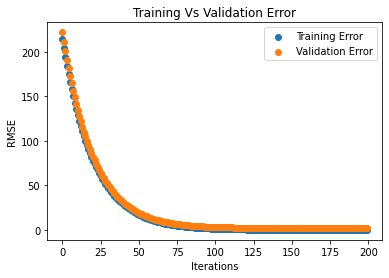

In [27]:
plt.scatter(x=training_rounds,y=xgb_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=xgb_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

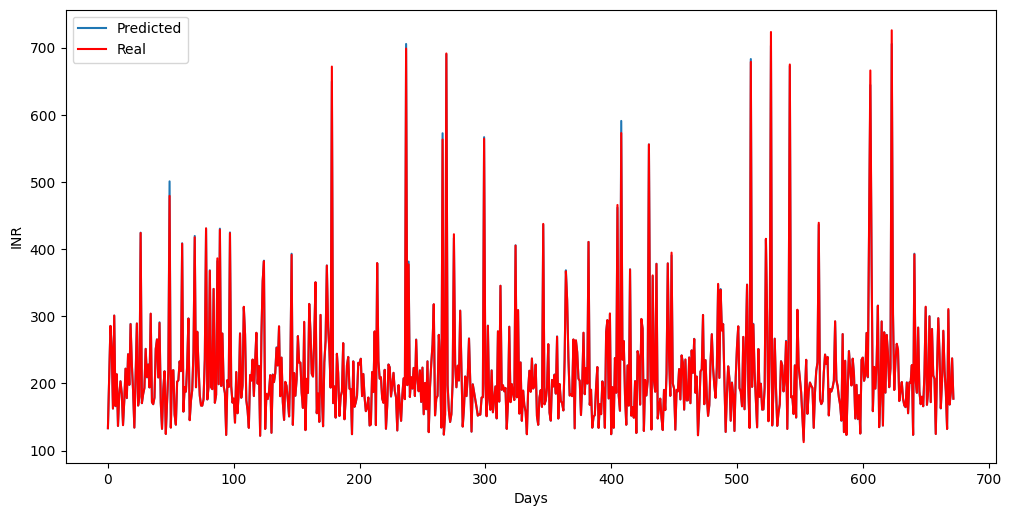

In [28]:
plt.figure(figsize=(12, 6), dpi=100)
x = list(range(0, len(Y_test), 1))
plt.plot(x,res, label='Predicted')
plt.plot(x,Y_test, color='red', label='Real')
plt.xlabel('Days')
plt.ylabel('INR')

plt.legend()
plt.show()

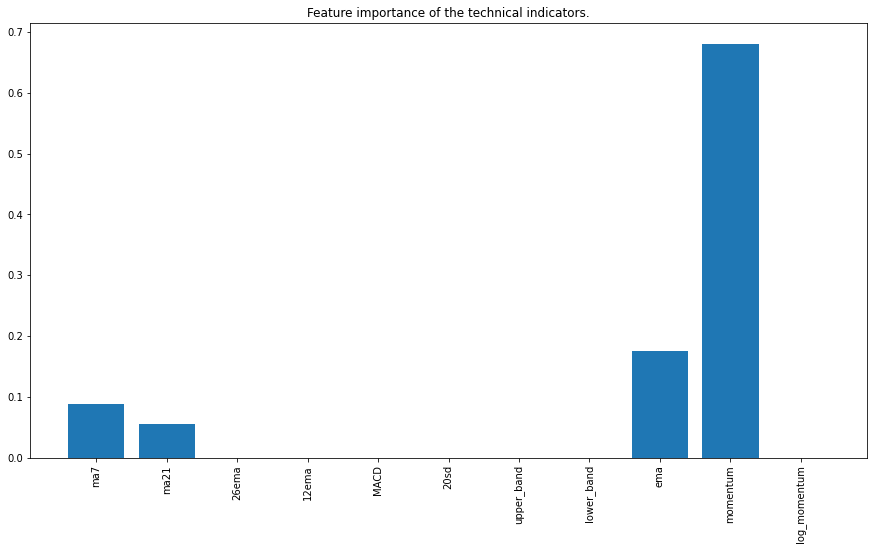

In [29]:
fig = plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_model.feature_importances_))], xgb_model.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Feature importance of the technical indicators.')
plt.show()

### Excluding Momentum, exponential moving average (ema) and log momentum

In [30]:
def feature_imp(df):
    data = df.copy()
#     data = data.drop(['Change %', 'Vol.', 'fft'], axis=1)
    data = data.drop(['momentum','log_momentum', 'ema'], axis=1)
    y = data['Price']
    X = data.iloc[:,1:]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.25, random_state=5)

    return (X_train, Y_train), (X_test, Y_test)

In [31]:
(X_train, Y_train), (X_test, Y_test) = feature_imp(df_tech_indi)

In [32]:
xgb_reg = xgb.XGBRegressor(gamma=0.0, n_estimators = 200, base_score = 0.5, colsample_bytree=1, learning_rate = 0.05)
xgb_reg

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=1,
             enable_categorical=False, gamma=0.0, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [33]:
xgb_model = xgb_reg.fit(X_train, Y_train, eval_metric="rmse", eval_set = [(X_train, Y_train),(X_test, Y_test)])

[0]	validation_0-rmse:214.34286	validation_1-rmse:221.86053
[1]	validation_0-rmse:203.76900	validation_1-rmse:211.10756
[2]	validation_0-rmse:193.72015	validation_1-rmse:200.89996
[3]	validation_0-rmse:184.16763	validation_1-rmse:191.13226
[4]	validation_0-rmse:175.09030	validation_1-rmse:181.84930
[5]	validation_0-rmse:166.46693	validation_1-rmse:173.09288
[6]	validation_0-rmse:158.26987	validation_1-rmse:164.72246
[7]	validation_0-rmse:150.48238	validation_1-rmse:156.78337
[8]	validation_0-rmse:143.08424	validation_1-rmse:149.17470
[9]	validation_0-rmse:136.05159	validation_1-rmse:141.93588
[10]	validation_0-rmse:129.36440	validation_1-rmse:135.09325
[11]	validation_0-rmse:123.01067	validation_1-rmse:128.61197
[12]	validation_0-rmse:116.97805	validation_1-rmse:122.40871
[13]	validation_0-rmse:111.24046	validation_1-rmse:116.52459
[14]	validation_0-rmse:105.78832	validation_1-rmse:110.95971
[15]	validation_0-rmse:100.60919	validation_1-rmse:105.68235
[16]	validation_0-rmse:95.68536	va

[140]	validation_0-rmse:4.29170	validation_1-rmse:10.98303
[141]	validation_0-rmse:4.27909	validation_1-rmse:10.97944
[142]	validation_0-rmse:4.26757	validation_1-rmse:10.97523
[143]	validation_0-rmse:4.25592	validation_1-rmse:10.97031
[144]	validation_0-rmse:4.24061	validation_1-rmse:10.96389
[145]	validation_0-rmse:4.22836	validation_1-rmse:10.96046
[146]	validation_0-rmse:4.21926	validation_1-rmse:10.95969
[147]	validation_0-rmse:4.21258	validation_1-rmse:10.95668
[148]	validation_0-rmse:4.19630	validation_1-rmse:10.95040
[149]	validation_0-rmse:4.18228	validation_1-rmse:10.94861
[150]	validation_0-rmse:4.16444	validation_1-rmse:10.94558
[151]	validation_0-rmse:4.15229	validation_1-rmse:10.94224
[152]	validation_0-rmse:4.14093	validation_1-rmse:10.93547
[153]	validation_0-rmse:4.13305	validation_1-rmse:10.93475
[154]	validation_0-rmse:4.12544	validation_1-rmse:10.93537
[155]	validation_0-rmse:4.10860	validation_1-rmse:10.93102
[156]	validation_0-rmse:4.09009	validation_1-rmse:10.927

In [34]:
xgb_result = xgb_reg.evals_result()

In [35]:
res = xgb_reg.predict(X_test)

In [36]:
training_rounds = range(0,len(xgb_result['validation_0']['rmse']))

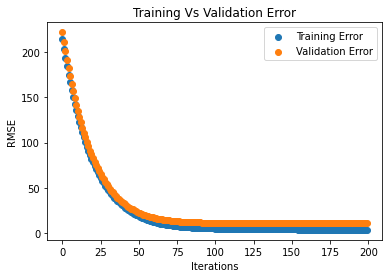

In [37]:
plt.scatter(x=training_rounds,y=xgb_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=xgb_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

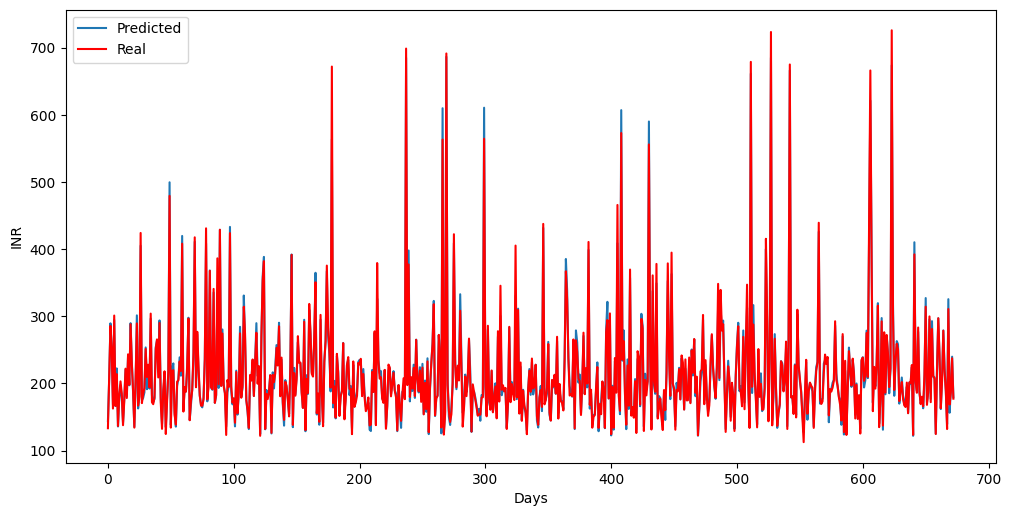

In [38]:
plt.figure(figsize=(12, 6), dpi=100)
x = list(range(0, len(Y_test), 1))
plt.plot(x,res, label='Predicted')
plt.plot(x,Y_test, color='red', label='Real')
plt.xlabel('Days')
plt.ylabel('INR')

plt.legend()
plt.show()

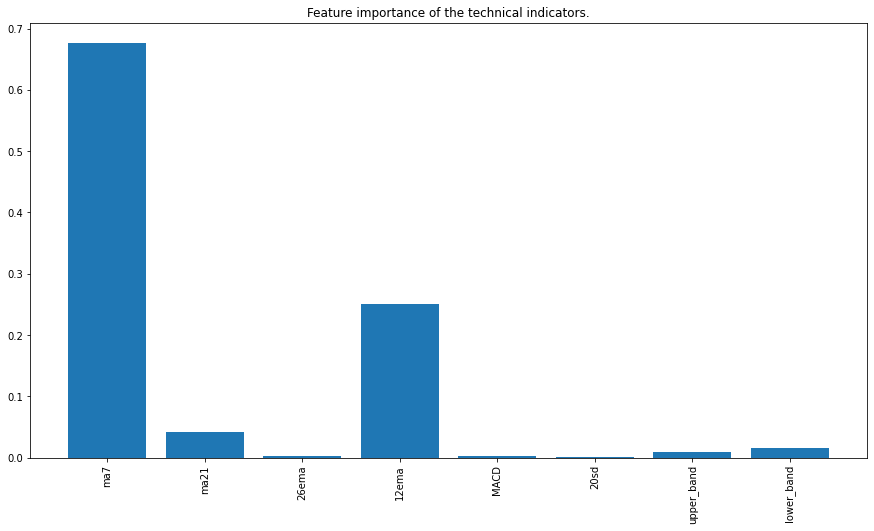

In [39]:
fig = plt.figure(figsize=(15,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgb_model.feature_importances_))], xgb_model.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Feature importance of the technical indicators.')
plt.show()